# Tutorial pyAgrum

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://pyagrum.gitlab.io) |[ ![interactive online version](images/atbinder.svg)](https://mybinder.org/v2/gl/agrumery%2FaGrUM/forBinder?urlpath=%2Fdoc%2Ftree%2Fwrappers%2Fpyagrum%2Fdoc%2Fsphinx%2Fnotebooks%2F01-Tutorial_pyAgrum.ipynb)


## Creating your first Bayesian network with pyAgrum

(This example is based on an OpenBayes [closed] website tutorial)

<p>A <b>Bayesian network</b> (BN) is composed of <b>random variables</b> (nodes) and their conditional dependencies (arcs) which, together, form a directed acyclic graph (DAG). A <b>conditional probability table</b> (CPT) is associated with each node. It contains the conditional probability distribution of the node given its parents in the DAG:</p>

<img src="images/waterprinkler.png">

Such a BN allows to manipulate the joint probability $P(C,S,R,W)$&nbsp;&nbsp;&nbsp;using this decomposition :

$$P(C,S,R,W)=\prod_X P(X | Parents_X) = P(C) \cdot P(S | C) \cdot P(R | C) \cdot P(W | S,R)$$

Imagine you want to create your first Bayesian network, say for example the 'Water Sprinkler' network. This is an easy example. All the nodes are Boolean (only 2 possible values). You can proceed as follows.


### Import the pyAgrum package

In [1]:
import pyagrum as gum

### Create the network topology

#### Create the BN

The next line creates an empty BN network with a 'name' property.

In [2]:
bn = gum.BayesNet("WaterSprinkler")
print(bn)

BN{nodes: 0, arcs: 0, domainSize: 1, dim: 0, mem: 0o}


#### Create the variables

pyAgrum(aGrUM) provides 5 types of variables :

- LabelizedVariable `{low|medium|high}` : a discrete variable that can take 3 values.
- RangeVariable `[3,10]` : a discrete variable that can take 8 values: from 3 to 10.
- IntegerVariable `{1|3|4|7}` : a discrete variable that can take 4 values
- NumericalDiscreteVariable `{1.0|3.14|4.6|7}` : another discrete
- variable that can take 4 values
- DiscretizedVariable `[1.0,3.0,6.0]` :a continuous variable discretized in 2 values 1-3 and 3-6.

In this tutorial, we will use LabelizedVariable, which is a variable whose domain is a finite set of labels. The next line will create a variable named 'c', with 2 values and described as 'cloudy?', and it will add it to the BN. The value returned is the id of the node in the graphical structure (the DAG). pyAgrum actually distinguishes the random variable (here the labelizedVariable) from its node in the DAG: the latter is identified through a numeric id. Of course, pyAg
rum provides functions to get the id of a node given the corresponding variable and conversely.

In [3]:
id_c = bn.add(gum.LabelizedVariable("c", "cloudy ?", 2))
print(id_c)

print(bn.variable(id_c))

0
c:Labelized({0|1})


You can go on adding nodes in the network this way. Let us use python to compact a little bit the code:

In [4]:
id_s, id_r, id_w = [
  bn.add(name, 2) for name in "srw"
]  # bn.add(name, 2) === bn.add(gum.LabelizedVariable(name, name, 2))
print(id_s, id_r, id_w)
print(bn)

1 2 3
BN{nodes: 4, arcs: 0, domainSize: 16, dim: 4, mem: 64o}


When you add a variable to a graphical model, this variable is "owned" by the model but you still have (read*only) accessors between the 3 related objects : the variable itself, its name and its id in the BN :

In [5]:
print(f"{bn.variable(id_s)=}")
print(f"{bn['s']=}")
print(f"{id_s=}")
print(f"{bn.idFromName('s')=}")
print(f"{bn.variable(id_s).name()=}")

bn.variable(id_s)=(pyagrum.DiscreteVariable@0xb70759020) s:Range([0,1])
bn['s']=(pyagrum.DiscreteVariable@0xb70759020) s:Range([0,1])
id_s=1
bn.idFromName('s')=1
bn.variable(id_s).name()='s'


#### Create the arcs

Now we have to connect nodes, i.e., to add arcs linking the nodes. Remember that <tt>id_c</tt> and <tt>id_s</tt> are ids for nodes. But we use directly access by name 
`"c"` or `"s"` 

In [6]:
bn.addArc("c", "s")

For adding multiple arcs, o
nce again, python can help us :

In [7]:
for link in [(id_c, id_r), ("s", "w"), ("r", "w")]:
  bn.addArc(*link)
print(bn)

BN{nodes: 4, arcs: 4, domainSize: 16, dim: 9, mem: 144o}


pyAgrum provides tools to display <tt>bn</tt> in more user-fri
endly fashions. <br/>Notably, <tt>pyagrum.lib</tt> is a set of tools written in pyAgrum to help using aGrUM in python. <tt>pyagrum.lib.notebook</tt> adds dedicated functions for iPython notebook.

In [8]:
import pyagrum.lib.notebook as gnb

bn

(pyagrum.BayesNet@0xb6e7fe400) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 9, mem: 144o}

#### Shorcuts with fastBN

The functions `fast[model]` encode the structure of the graphical model and the type of the variables in a concise language somehow derived from the `dot` language for graphs (see the doc for the underlying method : [fastPrototype](https://pyagrum.readthedocs.io/en/latest/BNModel.html?highlight=fastPrototype#pyagrum.BayesNet.fastPrototype)).

In [9]:
bn2 = gum.fastBN("c->r->w<-s<-c", "{No|Yes}")  # by default, variable is labelized {No|Yes}
bn2

(pyagrum.BayesNet@0xb6f0e4600) BN{nodes: 4, arcs: 4, domainSize: 16, dim: 9, mem: 144o}

In [10]:
print(bn2.variable("c"))
print(bn.variable("c"))
bn = bn2

c:Labelized({No|Yes})
c:Labelized({0|1})


### Create the probability tables

Once the network topology is constructed, we must initialize the conditional probability tables (CPT) distributions.
Each CPT is considered as a Tensor object in pyagrum. There are several ways to fill such an object.<br/>

To get the CPT of a variable, use the cpt method of your BayesNet instance with the variable's id as parameter.<br/>

Now we are ready to fill in the parameters of each node in our network. There are several ways to add these parameters.<br/>

#### Low-level way

In [11]:
bn.cpt(id_c).fillWith([0.4, 0.6])  # remember : c=  0

(pyagrum.Tensor@0xb6f83e8a0) 
  c                |
No       |Yes      |
---------|---------|
 0.4000  | 0.6000  |

Most of the methods using a node id will also work with name of the random variable.

In [12]:
bn.cpt("c").fillWith([0.5, 0.5])

(pyagrum.Tensor@0xb6f83e8a0) 
  c                |
No       |Yes      |
---------|---------|
 0.5000  | 0.5000  |

#### Using the order of variables

In [13]:
bn.cpt("s").names

('s', 'c')

In [14]:
bn.cpt("s")[:] = [[0.5, 0.5], [0.9, 0.1]]

Then $P(S | C=0)=[0.5,0.5]$ <br/>and $P(S | C=1)=[0.9,0.1]$.

In [15]:
print(bn.cpt("s")[1])

[0.9 0.1]


The same process can be performed in several steps:

In [16]:
bn.cpt("s")[0, :] = 0.5  # equivalent to [0.5,0.5]
bn.cpt("s")[1, :] = [0.9, 0.1]

In [17]:
print(bn.cpt("w").names)
bn.cpt("w")

('w', 'r', 's')


(pyagrum.Tensor@0xb6f83e840) 
             ||  w                |
r     |s     ||No       |Yes      |
------|------||---------|---------|
No    |No    || 0.8961  | 0.1039  |
Yes   |No    || 0.5428  | 0.4572  |
No    |Yes   || 0.3054  | 0.6946  |
Yes   |Yes   || 0.8255  | 0.1745  |

In [18]:
bn.cpt("w")[0, 0, :] = [1, 0]  # r=0,s=0
bn.cpt("w")[0, 1, :] = [0.1, 0.9]  # r=0,s=1
bn.cpt("w")[1, 0, :] = [0.1, 0.9]  # r=1,s=0
bn.cpt("w")[1, 1, :] = [0.01, 0.99]  # r=1,s=1

#### Using a dictionary

This is probably the most convenient way:

In [19]:
bn.cpt("w")[{"r": 0, "s": 0}] = [1, 0]
bn.cpt("w")[{"r": 0, "s": 1}] = [0.1, 0.9]
bn.cpt("w")[{"r": 1, "s": 0}] = [0.1, 0.9]
bn.cpt("w")[{"r": 1, "s": 1}] = [0.01, 0.99]
bn.cpt("w")

(pyagrum.Tensor@0xb6f83e840) 
             ||  w                |
r     |s     ||No       |Yes      |
------|------||---------|---------|
No    |No    || 1.0000  | 0.0000  |
Yes   |No    || 0.1000  | 0.9000  |
No    |Yes   || 0.1000  | 0.9000  |
Yes   |Yes   || 0.0100  | 0.9900  |

Subscripting with dictionaries is a feature borrowed from OpenBayes. It makes it easier to use and avoids common mistakes that happen when introducing data into the wrong places.

In [20]:
bn.cpt("r")[{"c": 0}] = [0.8, 0.2]
bn.cpt("r")[{"c": 1}] = [0.2, 0.8]

### Input/output

Now our BN is complete. It can be saved in different format :

In [21]:
print(gum.availableBNExts())

bif|dsl|net|bifxml|o3prm|uai|xdsl|pkl


In [22]:
# the preferred format is bifxml
gum.saveBN(bn, "out/WaterSprinkler.bifxml")

But we can save a BN using BIF format

In [23]:
gum.saveBN(bn, "out/WaterSprinkler.bif")

In [24]:
with open("out/WaterSprinkler.bif", "r") as out:
  print(out.read())

network "unnamedBN" {
// written by aGrUM 2.3.0.9
}

variable c {
   type discrete[2] {No, Yes};
}

variable r {
   type discrete[2] {No, Yes};
}

variable w {
   type discrete[2] {No, Yes};
}

variable s {
   type discrete[2] {No, Yes};
}

probability (c) {
   table 0.5 0.5;
}
probability (r | c) {
   (No) 0.8 0.2;
   (Yes) 0.2 0.8;
}
probability (w | r, s) {
   (No, No) 1 0;
   (Yes, No) 0.1 0.9;
   (No, Yes) 0.1 0.9;
   (Yes, Yes) 0.01 0.99;
}
probability (s | c) {
   (No) 0.5 0.5;
   (Yes) 0.9 0.1;
}




In [25]:
bn2 = gum.loadBN("out/WaterSprinkler.bif")

We can also save and load it in other formats

In [26]:
gum.saveBN(bn, "out/WaterSprinkler.net")
with open("out/WaterSprinkler.net", "r") as out:
  print(out.read())
bn3 = gum.loadBN("out/WaterSprinkler.net")


net {
  name = unnamedBN;
  software = "aGrUM 2.3.0.9";
  node_size = (50 50);
}

node c {
   states = (No Yes );
   label = "c";
   ID = "c";
}

node r {
   states = (No Yes );
   label = "r";
   ID = "r";
}

node w {
   states = (No Yes );
   label = "w";
   ID = "w";
}

node s {
   states = (No Yes );
   label = "s";
   ID = "s";
}

potential (c) {
   data = (  0.5 0.5);
}

potential ( r | c   ) {
   data = 
   ((    0.8    0.2)   % c=No   
   (    0.2    0.8));   % c=Yes   
}

potential ( w | r   s   ) {
   data = 
   (((    1    0)   % s=No   r=No   
   (    0.1    0.9))   % s=Yes   r=No   
   ((    0.1    0.9)   % s=No   r=Yes   
   (    0.01    0.99)));   % s=Yes   r=Yes   
}

potential ( s | c   ) {
   data = 
   ((    0.5    0.5)   % c=No   
   (    0.9    0.1));   % c=Yes   
}





In [27]:
# you can even use pickle
import pickle

with open("out/bn.pkl", "wb") as mypickle:
  pickle.dump(bn, file=mypickle)

# or even
gum.saveBN(bn, "out/bn.pkl")

**Note**: Bayesian network objects in pyAgrum have some specific features that are not supported by standard file formats (e.g., the different types of discrete variables). Only **BIFXML** and **Pickle** formats guarantee that all these specific features will be preserved when saving the network.

## Inference in Bayesian networks

We have to choose an inference engine to perform calculations for us. Many inference engines are currently available in pyAgrum:

- **Exact inference**, particularly :
    - `gum.LazyPropagation` : an exact inference method that transforms the Bayesian network into a hypergraph called a join tree or a junction tree. This tree is constructed in order to optimize inference computations.
    - others: `gum.VariableElimination`, `gum.ShaferShenoy`, ...
        
- **Samplig Inference** : approximate inference engine using sampling algorithms to generate a sequence of samples from the joint probability distribution (`gum.GibbSSampling`, etc.)
- **Loopy Belief Propagation** : approximate inference engine using inference algorithm exact for trees but not for DAG

In [28]:
ie = gum.LazyPropagation(bn)

### Inference without evidence

In [29]:
ie.makeInference()
print(ie.posterior("w"))


  w                |
No       |Yes      |
---------|---------|
 0.3529  | 0.6471  |



In [30]:
from IPython.core.display import HTML

HTML(f"In our BN, $P(W)=${ie.posterior('w')[:]}")

With notebooks, it can be viewed as an HTML table

In [31]:
ie.posterior("w")[:]

array([0.3529, 0.6471])

### Inference with evidence

Suppose now that you know that the sprinkler is on and that it is not cloudy, and you wonder what Is the probability of the grass being wet, i.e., you are interested in distribution $P(W|S=1,C=0)$. <br/>The new knowledge you have (sprinkler is on and it is not cloudy) is called evidence. Evidence is entered using a dictionary. When you know precisely the value taken by a random variable, the evidence is called a hard evidence. This is the case, for instance, when I know for sure that the sprinkler is on. In this case, the knowledge is entered in the dictionary as 'variable name':label

In [32]:
ie.setEvidence({"s": 0, "c": 0})
ie.makeInference()
ie.posterior("w")

(pyagrum.Tensor@0xb6f83ee80) 
  w                |
No       |Yes      |
---------|---------|
 0.8200  | 0.1800  |

When you have incomplete knowledge about the value of a random variable, this is called a soft evidence. In this case, this evidence is entered as the belief you have over the possible values that the random variable can take, in other words, as <em>P(evidence|true value of the variable)</em>. Imagine for instance that you think that if the sprinkler is off, you have only 50% chances of knowing it, but if it is on, you are sure to know it. Then, your belief about the state of the sprinkler is [0.5, 1] and you should enter this knowledge as shown below. Of course, hard evidence are special cases of soft evidence in which the beliefs over all the values of the random variable but one are equal to 0.

In [33]:
ie.setEvidence({"s": [0.5, 1], "c": [1, 0]})
ie.makeInference()
ie.posterior("w")  # using gnb's feature

(pyagrum.Tensor@0xb6f83eea0) 
  w                |
No       |Yes      |
---------|---------|
 0.3280  | 0.6720  |

the pyagrum.lib.notebook utility proposes certain functions to graphically show distributions.

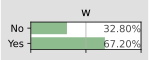

In [34]:
gnb.showProba(ie.posterior("w"))

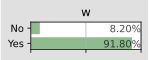

In [35]:
gnb.showPosterior(bn, {"s": 1, "c": 0}, "w")

### inference in the whole Bayes net

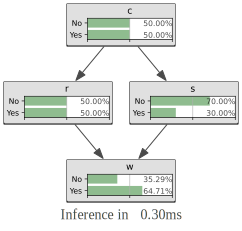

In [36]:
gnb.showInference(bn, evs={})

#### inference with hard evidence

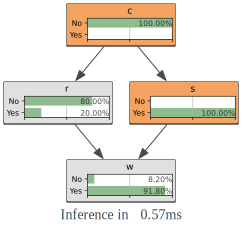

In [37]:
gnb.showInference(bn, evs={"s": 1, "c": 0})

#### inference with soft and hard evidence

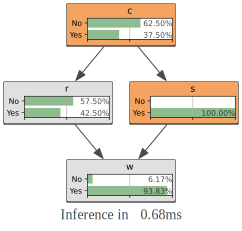

In [38]:
gnb.showInference(bn, evs={"s": 1, "c": [0.3, 0.9]})

#### inference with partial targets

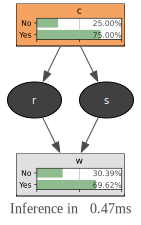

In [39]:
gnb.showInference(bn, evs={"c": [0.3, 0.9]}, targets={"c", "w"})

## Testing independence in Bayesian networks

One of the strength of the Bayesian networks is to form a model that allows to read qualitative knowledge directly from the graph
: the conditional independence. aGrUM/pyAgrum comes with a set of tools to query this qualitative knowledge.

In [40]:
# fast create a BN (random paramaters are chosen for the CPTs)
bn = gum.fastBN("A->B<-C->D->E<-F<-A;C->G<-H<-I->J")
bn

(pyagrum.BayesNet@0xb6f0e4c00) BN{nodes: 10, arcs: 10, domainSize: 1024, dim: 23, mem: 368o}

## Conditional Independence

### Directly
First, one can directly test independence

In [41]:
def testIndep(bn, x, y, knowing):
  res = "" if bn.isIndependent(x, y, knowing) else " NOT"
  giv = "." if len(knowing) == 0 else f" given {knowing}."
  print(f"{x} and {y} are{res} independent{giv}")


testIndep(bn, "A", "C", [])
testIndep(bn, "A", "C", ["E"])
print()
testIndep(bn, "E", "C", [])
testIndep(bn, "E", "C", ["D"])
print()
testIndep(bn, "A", "I", [])
testIndep(bn, "A", "I", ["E"])
testIndep(bn, "A", "I", ["G"])
testIndep(bn, "A", "I", ["E", "G"])

A and C are independent.
A and C are NOT independent given ['E'].

E and C are NOT independent.
E and C are independent given ['D'].

A and I are independent.
A and I are independent given ['E'].
A and I are independent given ['G'].
A and I are NOT independent given ['E', 'G'].


### Markov Blanket

Second, one can investigate the Markov Blanket of a node. The Markov blanket of a node $X$ is the set of nodes $M\!B(X)$ such that $X$ is independent from the rest of the nodes given $M\!B(X)$.

In [42]:
print(gum.MarkovBlanket(bn, "C").toDot())
gum.MarkovBlanket(bn, "C")

digraph "no_name" {
node [shape = ellipse];
  0[label="A"];
  1[label="B"];
  2[label="C", color=red];
  3[label="D"];
  6[label="G"];
  7[label="H"];

  0 -> 1;
  2 -> 3;
  2 -> 1;
  2 -> 6;
  7 -> 6;

}



<pyagrum.pyagrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x110cc82d0> >

In [43]:
gum.MarkovBlanket(bn, "J")

<pyagrum.pyagrum.MarkovBlanket; proxy of <Swig Object of type 'gum::MarkovBlanket *' at 0x10fc58d20> >

### Minimal conditioning set and evidence Impact using probabilistic inference

For a variable and a list of variables, one can find the sublist that effectively impacts the variable if the list of variables was observed.

In [44]:
[bn.variable(i).name() for i in bn.minimalCondSet("B", ["A", "H", "J"])]

['A']

In [45]:
[bn.variable(i).name() for i in bn.minimalCondSet("B", ["A", "G", "H", "J"])]

['A', 'G', 'H']

This can be also viewed when using `gum.LazyPropagation.evidenceImpact(target,evidence)` which computes $P(target|evidence)$ but reduces as much as possible the set of needed evidence for the result :

In [46]:
ie = gum.LazyPropagation(bn)
ie.evidenceImpact("B", ["A", "C", "H", "G"])  # H,G will be removed w.r.t the minimalCondSet above

(pyagrum.Tensor@0xb714772a0) 
             ||  B                |
A     |C     ||0        |1        |
------|------||---------|---------|
0     |0     || 0.0945  | 0.9055  |
1     |0     || 0.3454  | 0.6546  |
0     |1     || 0.9102  | 0.0898  |
1     |1     || 0.7568  | 0.2432  |

In [47]:
ie.evidenceImpact("B", ["A", "G", "H", "J"])  # "J" is not necessary to compute the impact of the evidence

(pyagrum.Tensor@0xb71476840) 
                    ||  B                |
G     |H     |A     ||0        |1        |
------|------|------||---------|---------|
0     |0     |0     || 0.8347  | 0.1653  |
1     |0     |0     || 0.8331  | 0.1669  |
0     |1     |0     || 0.8531  | 0.1469  |
1     |1     |0     || 0.6070  | 0.3930  |
0     |0     |1     || 0.7188  | 0.2812  |
1     |0     |1     || 0.7180  | 0.2820  |
0     |1     |1     || 0.7280  | 0.2720  |
1     |1     |1     || 0.6039  | 0.3961  |

### PS- the complete code to create the first image

In [48]:
bn = gum.fastBN("Cloudy?->Sprinkler?->Wet Grass?<-Rain?<-Cloudy?")

bn.cpt("Cloudy?").fillWith([0.5, 0.5])

bn.cpt("Sprinkler?")[:] = [[0.5, 0.5], [0.9, 0.1]]

bn.cpt("Rain?")[{"Cloudy?": 0}] = [0.8, 0.2]
bn.cpt("Rain?")[{"Cloudy?": 1}] = [0.2, 0.8]

bn.cpt("Wet Grass?")[{"Rain?": 0, "Sprinkler?": 0}] = [1, 0]
bn.cpt("Wet Grass?")[{"Rain?": 0, "Sprinkler?": 1}] = [0.1, 0.9]
bn.cpt("Wet Grass?")[{"Rain?": 1, "Sprinkler?": 0}] = [0.1, 0.9]
bn.cpt("Wet Grass?")[{"Rain?": 1, "Sprinkler?": 1}] = [0.01, 0.99]

# the next line control the number of visible digits
gum.config["notebook", "tensor_visible_digits"] = 2
gnb.sideBySide(bn.cpt("Cloudy?"), captions=["$P(Cloudy)$"])
gnb.sideBySide(
  bn.cpt("Sprinkler?"),
  gnb.getBN(bn, size="3!"),
  bn.cpt("Rain?"),
  captions=["$P(Sprinkler|Cloudy)$", "", "$P(WetGrass|Sprinkler,Rain)$"],
)
gnb.sideBySide(bn.cpt("Wet Grass?"), captions=["$P(WetGrass|Sprinkler,Rain)$"])

### PS2- a second glimpse of `gum.config`

(for more, see the notebook : config for pyAgrum)

In [49]:
bn = gum.fastBN("Cloudy?->Sprinkler?->Wet Grass?<-Rain?<-Cloudy?")

bn.cpt("Cloudy?").fillWith([0.5, 0.5])

bn.cpt("Sprinkler?")[:] = [[0.5, 0.5], [0.9, 0.1]]

bn.cpt("Rain?")[{"Cloudy?": 0}] = [0.8, 0.2]
bn.cpt("Rain?")[{"Cloudy?": 1}] = [0.2, 0.8]

bn.cpt("Wet Grass?")[{"Rain?": 0, "Sprinkler?": 0}] = [1, 0]
bn.cpt("Wet Grass?")[{"Rain?": 0, "Sprinkler?": 1}] = [0.1, 0.9]
bn.cpt("Wet Grass?")[{"Rain?": 1, "Sprinkler?": 0}] = [0.1, 0.9]
bn.cpt("Wet Grass?")[{"Rain?": 1, "Sprinkler?": 1}] = [0.01, 0.99]

# the next lines control the visualisation of proba as fraction
gum.config["notebook", "tensor_with_fraction"] = True
gum.config["notebook", "tensor_fraction_with_latex"] = True
gum.config["notebook", "tensor_fraction_limit"] = 100

gnb.sideBySide(bn.cpt("Cloudy?"), captions=["$P(Cloudy)$"])
gnb.sideBySide(
  bn.cpt("Sprinkler?"),
  gnb.getBN(bn, size="3!"),
  bn.cpt("Rain?"),
  captions=["$P(Sprinkler|Cloudy)$", "", "$P(WetGrass|Sprinkler,Rain)$"],
)
gnb.sideBySide(bn.cpt("Wet Grass?"), captions=["$P(WetGrass|Sprinkler,Rain)$"])